<a href="https://colab.research.google.com/github/jana-jovicic/Neural-Style-Transfer/blob/master/01_Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip images.zip

Archive:  images.zip
   creating: images/
  inflating: images/content16.jpg    
  inflating: images/content15.jpg    
  inflating: images/van-gogh-the-starry-night.jpg  
  inflating: images/van-gogh-landscape-with-olive-trees.jpg  
  inflating: images/seurat-A-Sunday-on-La-Grande-Jatte.jpg  
  inflating: images/picasso-muse.jpg  
  inflating: images/munch-the-scream.jpg  
  inflating: images/manet-water-lilies.jpg  
  inflating: images/klimt-The-Tree-Of-Life.jpg  
  inflating: images/klimt-the-kiss.jpg  
  inflating: images/hokusai-the-great-wave-off-kanagawa.jpg  
  inflating: images/friedrich-the-wanderer-above-the-sea-of-fog.jpg  
  inflating: images/dali-spider-of-the-evening.jpg  
  inflating: images/dali-melting-watch.jpg  
  inflating: images/dali-galatea-of-the-spheres.jpg  
  inflating: images/content14.jpg    
  inflating: images/content13.jpg    
  inflating: images/content12.jpg    
  inflating: images/content11.jpg    
  inflating: images/content10.jpg    
  inflating: ima

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time
import functools
import os
import IPython.display

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing import image as kp_image
from tensorflow.keras.models import Model

In [0]:
def load_image(image_path):
  image = Image.open(image_path)
  image = image.resize((512, 512), Image.ANTIALIAS)
  image = kp_image.img_to_array(image) 
  # add new axis to get shape (batch_size, h, w, d)
  image = np.expand_dims(image, axis=0)
  return image


def show_image(image, title):

  # if additional axis was added, remove it
  if len(image.shape) > 3:
    image = np.squeeze(image, axis=0)
  image = image.astype('uint8')

  fig, axis1 = plt.subplots(1, 1, figsize=(14, 7))
  axis1.imshow(image)
  axis1.set_title(title)
  plt.show()

In [5]:
content_image_path = 'images' + os.path.sep + 'content6.jpg'
style_image_path = 'images' + os.path.sep + 'munch-the-scream.jpg'

content_image = load_image(content_image_path)
style_image = load_image(style_image_path)

content_image.shape, style_image.shape

((1, 512, 512, 3), (1, 512, 512, 3))

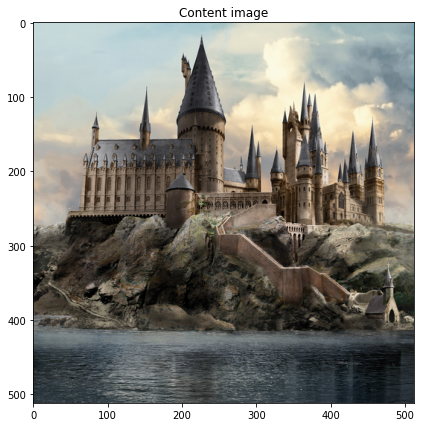

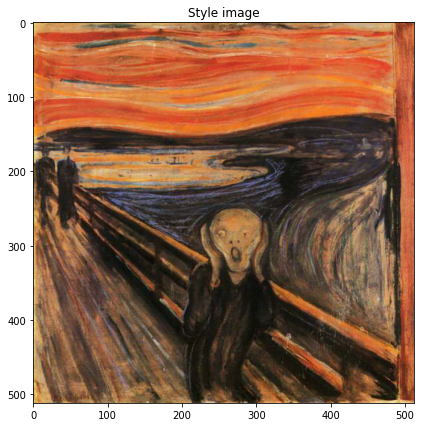

In [6]:
show_image(content_image, 'Content image')
show_image(style_image, 'Style image')

In [7]:
vgg19_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
for layer in vgg19_model.layers:
  print(layer.name)

80142336/80134624 [==============================] - 1s 0us/step
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [0]:
content_layers = ['block5_conv2'] 
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
content_layers_number = len(content_layers)
style_layers_number = len(style_layers)

In [0]:
def create_small_vgg_model(vgg_model, content_layers, style_layers):
  vgg_model.trainable = False
  output_layers = [vgg_model.get_layer(layer).output for layer in style_layers + content_layers]
  model = Model(vgg_model.input, output_layers)
  return model

In [0]:
def deprocess_img(processed_img):

  vgg_means = np.array([103.939, 116.779, 123.68])

  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  # assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
  #                            "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # inverse of the preprocessing step
  x[:, :, 0] += vgg_means[0]
  x[:, :, 1] += vgg_means[1]
  x[:, :, 2] += vgg_means[2]
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [0]:
def calculate_content_loss(F, P):
  '''
    Input: F, P - feature representations of generated and original image
  '''
  return tf.reduce_mean((F - P)**2)

In [0]:
def gram_matrix(F, N, M):
  '''
    Input: F - tensor; feature represenatation of image in given layer
           N - number of distinctive filters (and feature maps) in given layer
           M - size of each feature map in given layer (hight*width of map)
  '''
  # Reshape the tensor so it is a 2-dim matrix
  F = tf.reshape(F, (M, N))
  return tf.matmul(tf.transpose(F), F)

In [0]:
def calculate_style_loss_in_one_layer(g, a):
  ''' 
  Calculate the style loss at a certain layer
  Input:  a - feature representation of the style image at given layer
          g - feature representation of the generated image at given layer
  '''
  height, width, N = g.get_shape().as_list()
  M = height * width
  G = gram_matrix(g, N, M)
  A = gram_matrix(a, N, M)
  E = tf.reduce_sum((G - A) ** 2) / (4 * (N**2) * (M**2))
  #E = tf.reduce_sum((G - A) ** 2) / (4.0 * N * M)
  #E = tf.reduce_mean((G - A) ** 2)
  return E

In [0]:
def calculate_loss(model, style_weight, content_weight, initial_img, style_features, content_features):

  model_outputs = model(initial_img)
  
  style_output_features = model_outputs[:style_layers_number]
  content_output_features = model_outputs[style_layers_number:]
  
  style_loss = 0
  content_loss = 0

  # Accumulate style losses from all layers
  # We equally weight each contribution of each loss layer
  w_style = 1.0 / float(style_layers_number)
  for target_style, generated_style in zip(style_features, style_output_features):
    style_loss += w_style * calculate_style_loss_in_one_layer(generated_style[0], target_style)
    
  # Accumulate content losses from all layers 
  #w_content = 1.0 / float(content_layers_number)
  for target_content, generated_content in zip(content_features, content_output_features):
    content_loss += calculate_content_loss(generated_content[0], target_content)
  
  style_loss *= style_weight
  content_loss *= content_weight

  # Get total loss
  total_loss = style_loss + content_loss 
  return total_loss, style_loss, content_loss

In [0]:
def stylize_image(content_path, style_path, vgg_model, iterations=500, content_weight=1000.0, style_weight=0.01, print_images=False): 
  
  model = create_small_vgg_model(vgg_model, content_layers, style_layers)
  for layer in model.layers:
    layer.trainable = False

  content_img = load_image(content_path)
  style_img = load_image(style_path)
  initial_img = load_image(content_path)

  content_img = tf.keras.applications.vgg19.preprocess_input(content_img)
  style_img = tf.keras.applications.vgg19.preprocess_input(style_img)
  initial_img = tf.keras.applications.vgg19.preprocess_input(initial_img)
  initial_img = tf.Variable(initial_img, dtype=tf.float32)  

  style_outputs = model(style_img)
  content_outputs = model(content_img)
  #print(style_outputs)

  # Get the style and content feature representations from model  
  style_features = [style_layer[0] for style_layer in style_outputs[:style_layers_number]]
  content_features = [content_layer[0] for content_layer in content_outputs[style_layers_number:]]
  
  optimizer = tf.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

  best_loss = float('inf')
  best_img =  None

  display_image_interval = iterations / 10
  
  start_time = time.time()
  
  for i in range(iterations):
    
    with tf.GradientTape() as tape: 
      total_loss, style_score, content_score = calculate_loss(model, style_weight, content_weight, initial_img, style_features, content_features)
      gradients = tape.gradient(total_loss, initial_img)
    
    optimizer.apply_gradients([(gradients, initial_img)])

    if total_loss < best_loss:
      best_loss = total_loss
      best_img = deprocess_img(initial_img.numpy())

    if print_images:
      if (i % display_image_interval == 0) or (i == iterations-1):
        plot_img = initial_img.numpy()
        plot_img = deprocess_img(plot_img)
        show_image(plot_img, 'Stylized image')
        print('Iteration: {0}, total loss: {1}, style score: {2}, content score: {3}'
        .format(i, total_loss, style_score, content_score))

  print('Stylizing of image took: {0}s'.format(time.time() - start_time))
  return best_img, best_loss 

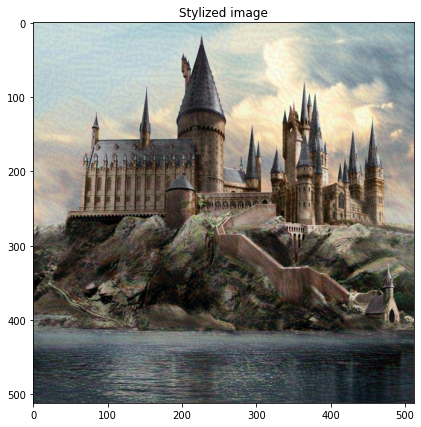

Iteration: 0, total loss: 224806512.0, style score: 224806512.0, content score: 0.0


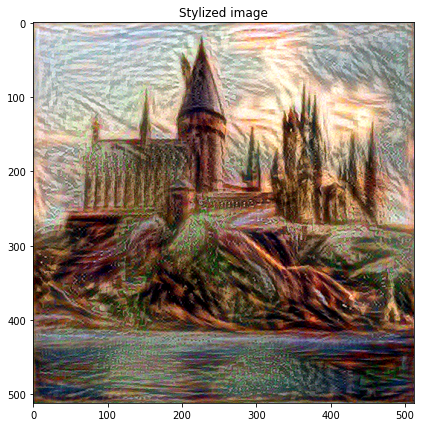

Iteration: 50, total loss: 13092600.0, style score: 10893183.0, content score: 2199417.0


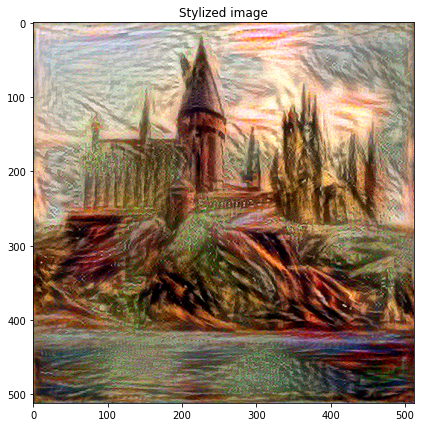

Iteration: 100, total loss: 6987386.5, style score: 5009141.5, content score: 1978245.125


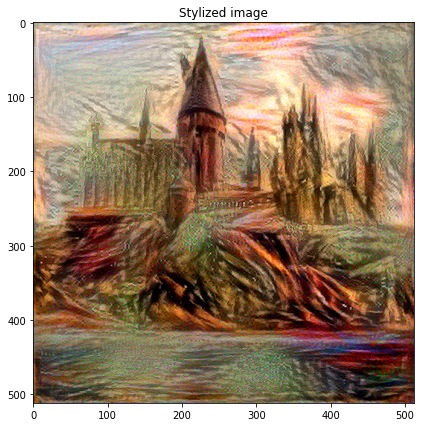

Iteration: 150, total loss: 4510113.0, style score: 2799634.75, content score: 1710478.125


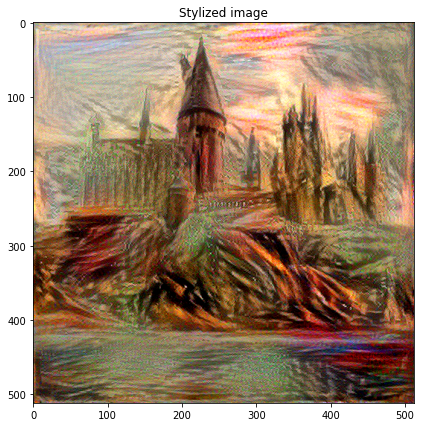

Iteration: 200, total loss: 3197906.5, style score: 1752721.625, content score: 1445184.75


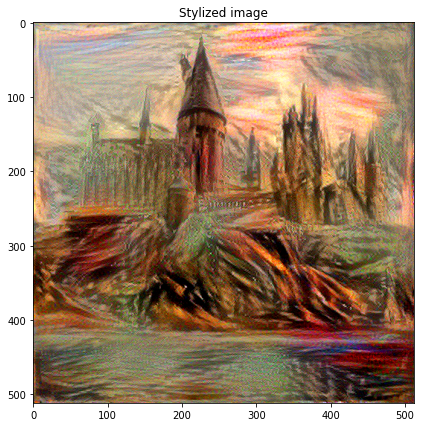

Iteration: 250, total loss: 2421366.5, style score: 1179670.875, content score: 1241695.5


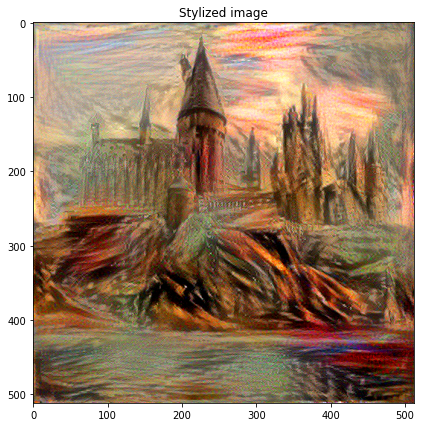

Iteration: 300, total loss: 1938595.625, style score: 861658.625, content score: 1076937.0


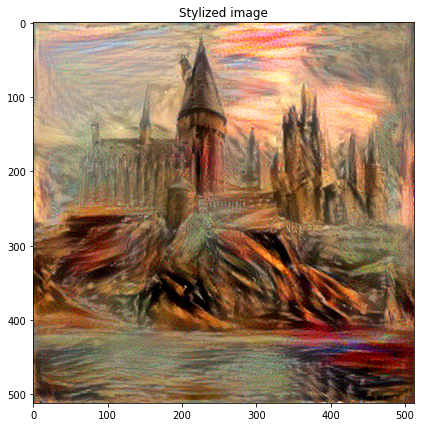

Iteration: 350, total loss: 1624443.25, style score: 669499.4375, content score: 954943.75


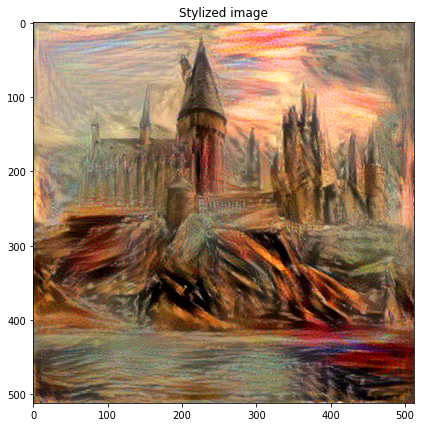

Iteration: 400, total loss: 1414325.5, style score: 547551.625, content score: 866773.875


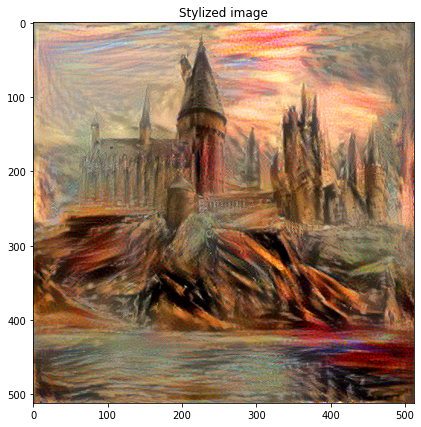

Iteration: 450, total loss: 1267621.75, style score: 469762.3125, content score: 797859.5


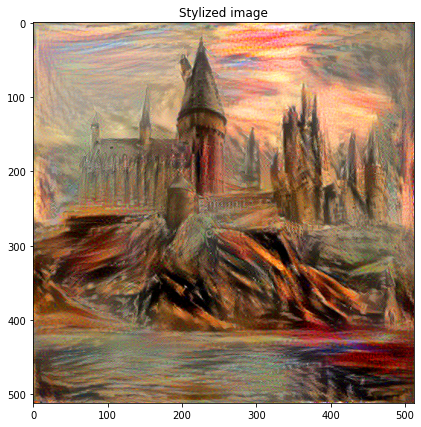

Iteration: 499, total loss: 1163290.25, style score: 418637.3125, content score: 744653.0
Stylizing of image took: 113.01554584503174s


In [16]:
content_image_path = 'images' + os.path.sep + 'content6.jpg'
style_image_path = 'images' + os.path.sep + 'munch-the-scream.jpg'
stylized_image, loss = stylize_image(content_image_path, style_image_path, vgg19_model, iterations=500, content_weight=1000.0, style_weight=0.1, print_images=True)